# Particle Flow Regression Notebook
### Goal:
The goal of this notebook is to set up a baseline energyflow regression from data files created in ClustersAndTracks.ipynb

Different data sets explored:
- [x] Single track data with only tracks
- [x] Cluster only data with energy_calib_tot as target
- [x] Single Track, Single Cluster
- [x] Single Track, Multiple Cluster
- [ ] Multiple track
- [ ] Mixed data with track and no track

### Implementation:
Load X array of data from .npy file and target Y
Normalize data, note all normalization is done in the notebook here!
Perform regression on this data-set

#### To Do:
- [ ] Add neutral pion data in the same manner as charged pion and shuffle them
- [x] Adding track information as extra point in the point cloud
- [x] Track only regression on Pt and truthPartPt
- [x] Cluster Only Regression
- [x] Combined cluster and track regression
- [x] Single track Single Cluster
- [x] Single Track Multiple Cluster
- [ ] Larger training data sets

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
from matplotlib.colors import LogNorm
import uproot as ur
import awkward as ak
import time as t
import copy
import scipy.constants as spc
print("Awkward version: "+str(ak.__version__))
print("Uproot Version: "+str(ur.__version__))

import sys
sys.path.append('/home/russbate/MLPionCollaboration/LCStudies/')
from util import resolution_util as ru
from util import plot_util as pu

Awkward version: 1.4.0
Uproot Version: 4.0.11


In [29]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "4,5"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [30]:
import tensorflow as tf

In [31]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']
get_available_gpus()

2021-07-28 14:54:13.298952: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-07-28 14:54:13.446043: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1746] Found device 0 with properties: 
pciBusID: 0000:88:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2021-07-28 14:54:13.449204: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1746] Found device 1 with properties: 
pciBusID: 0000:89:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2021-07-28 14:54:13.535277: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-07-28 14:54:13.551197: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
20

['/device:GPU:0', '/device:GPU:1']

-07-28 14:54:13.598638: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1293]      0 1 
2021-07-28 14:54:13.599966: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1306] 0:   N N 
2021-07-28 14:54:13.599979: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1306] 1:   N N 
2021-07-28 14:54:13.618681: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1432] Created TensorFlow device (/device:GPU:0 with 9666 MB memory) -> physical GPU (device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:88:00.0, compute capability: 7.5)
2021-07-28 14:54:13.625286: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1432] Created TensorFlow device (/device:GPU:1 with 9666 MB memory) -> physical GPU (device: 1, name: GeForce RTX 2080 Ti, pci bus id: 0000:89:00.0, compute capability: 7.5)


In [32]:
# energyflow imports
import energyflow as ef
from energyflow.archs import PFN

### Functions

In [33]:
def tvt_num(_data, _tvt=(75, 10, 15)):
    ''' Function designed to output appropriate numbers for traning validation and testing given
    a variable length input. TVT expressed as ratios and do not need to add to 100. '''
    _tot = len(_data)
    _train, _val, _test = _tvt
    _tvt_sum = _train + _val + _test
    
    _train_rtrn = round(_train*_tot/_tvt_sum)
    _val_rtrn = round(_val*_tot/_tvt_sum)
    _test_rtrn = _tot - _train_rtrn - _val_rtrn
    
    return _train_rtrn, _val_rtrn, _test_rtrn

def normalize_input1d(arr, mask):
    ''' Note that non masked values are left alone i.e. zeros if mask = arr != 0'''
    len_arr = arr.shape[0]
    mean = np.repeat(np.mean(arr, where=mask), len_arr)
    std_dev = np.repeat(np.std(arr, where=mask), len_arr)
    norm_arr = np.subtract(arr, mean, out=arr, where=mask)
    std_mask = np.logical_and(std_dev!=0, mask)
    norm_arr = np.divide(norm_arr, std_dev, out=norm_arr, where=std_mask)
    return norm_arr

def normalize_input2d(arr, mask):
    ''' Truth value is where to perform the operation, exclude False vals.
    returns: Array with the shape of arr with normalization carried out with mask '''
    len_ax1 = arr.shape[1]
    mean = np.tile(np.mean(arr, axis=1, where=mask), (len_ax1,1)).transpose()
    std_dev = np.tile(np.std(arr, axis=1, where=mask), (len_ax1,1)).transpose()
    norm_arr = np.subtract(arr, mean, out=arr, where=mask)
    std_mask = np.logical_and(std_dev != 0, mask)
    norm_arr = np.divide(norm_arr, std_dev, out=norm_arr, where=std_mask)
    return norm_arr

## Load Data

### Data Including Tracks
### X = [Energy, Eta, Phi, rPerp, Track Flag, Layer]
Note: Possible mistake in Y, was [clusterCalib, truthPartE, truthPartPt]
### Y = [truthPartE]

In [7]:
t0 = t.time()
dat = np.load('/data/rbate/XY_STSC_allFiles.npz', mmap_mode='r+')
print(dat.files)
t1 = t.time()
print('Time to load memory mapped data: '+str(t1-t0)+' (s)')

['arr_0', 'arr_1']
Time to load memory mapped data: 0.00689244270324707 (s)


In [21]:
t0 = t.time()
X = np.ndarray.copy(dat['arr_0'][:175000,:,:5])
Y = np.ndarray.copy(dat['arr_1'][:175000])
# X = dat['arr_0'][:500000,:,:5]
# Y = dat['arr_1'][:500000]
print(X.shape)
print(Y.shape)
t1 = t.time()

print('Time to copy arrays: '+str(t1-t0)+' (s)')

(175000, 1001, 5)
(175000,)
Time to copy arrays: 63.95803666114807 (s)


### Target Normalization

In [22]:
# the target energy values
N_evts = len(Y)
print(N_evts)

Y = np.log(Y)

175000


#### Show Target

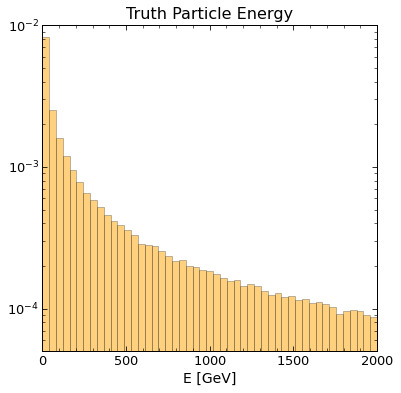

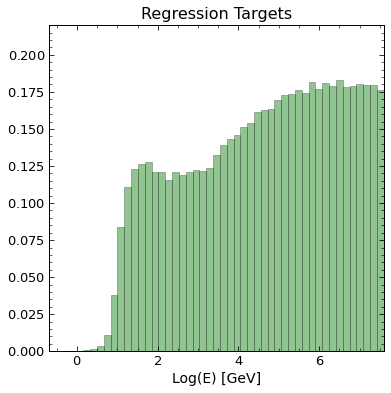

In [23]:
## RAW DATA ##
#=================================================================
fig = plt.figure(figsize=(6,6))
bins=np.linspace(0,2000,50,endpoint=True)
plt.hist(dat['arr_1'][:175000], color='orange', bins=bins, density=True, alpha=.5, edgecolor='black',
        label='raw regression target')
plt.title('Truth Particle Energy', fontsize=16)
plt.xlabel('E [GeV]', fontsize=14)
plt.xlim(np.min(bins),np.max(bins))
plt.yscale('log')
plt.ylim(.00005,.01)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
# plt.tight_layout()
# plt.savefig('Regression_Plots/July/EnergyTargets_STSC_raw_2021-07-15.png', format='png')
plt.show()

## NORMALIZED DATA ##
#=================================================================
fig = plt.figure(figsize=(6,6))
bins=np.linspace(np.log(.5), np.log(2000), 50, endpoint=True)
plt.hist(Y, color='forestgreen', bins=bins, density=True, alpha=.5, edgecolor='black',
        label='log')
plt.title('Regression Targets', fontsize=16)
plt.xlabel('Log(E) [GeV]', fontsize=14)
plt.xlim(np.min(bins),np.max(bins))
plt.ylim(0,.22)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
# plt.tight_layout()
# plt.savefig('Regression_Plots/July/EnergyTargets_STSC_log_2021-07-08.png', format='png')
plt.show()

### Data Normalization

In [24]:
## Normalize rPerp to 1/3630
rPerp_mask = X[:,:,3] != 0
X[:,:,3][rPerp_mask] = X[:,:,3][rPerp_mask]/3630.

## Energy Values that are not zero!
E_nonZeroMask = X[:,:,0] != 0
X[:,:,0][E_nonZeroMask] = np.log(X[:,:,0][E_nonZeroMask])
cellE_mean = np.mean(X[:,:,0][E_nonZeroMask])
cellE_std = np.std(X[:,:,0][E_nonZeroMask])
X[:,:,0][E_nonZeroMask] = (X[:,:,0][E_nonZeroMask] - cellE_mean)/cellE_std

## Eta and Phi
# do nothing for now as a control and check performance
eta_mask = X[:,:,1] != 0
X[:,:,1][eta_mask] = X[:,:,1][eta_mask]/.7

phi_mask = X[:,:,2] != 0
cellPhi_std = np.std(X[:,:,2][phi_mask])
X[:,:,2][phi_mask] = X[:,:,2][phi_mask]/cellPhi_std

#### Show Inputs

<Figure size 799.992x599.976 with 0 Axes>

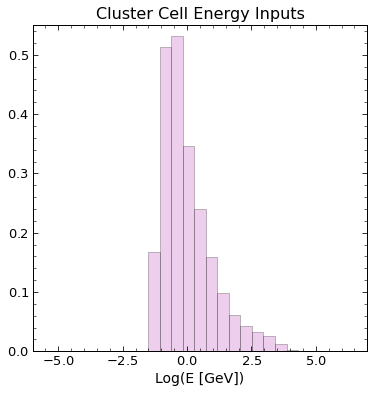

<Figure size 799.992x599.976 with 0 Axes>

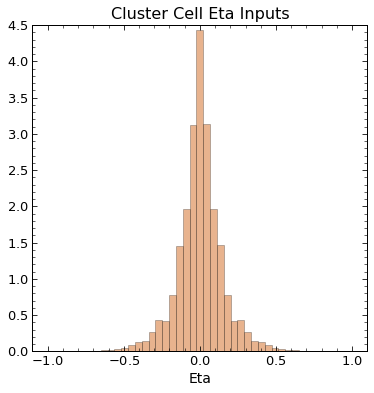

<Figure size 799.992x599.976 with 0 Axes>

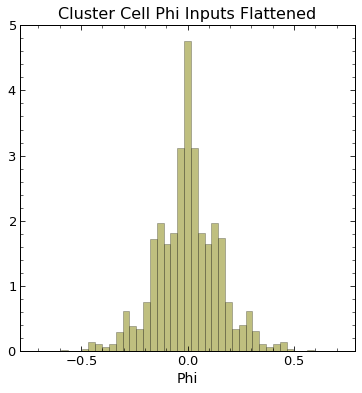

<Figure size 799.992x599.976 with 0 Axes>

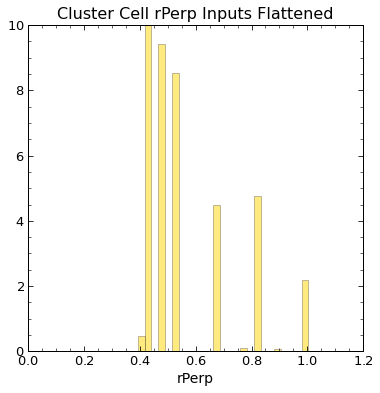

In [25]:
############
## ENERGY ##
############
plt.cla(); plt.clf()
fig = plt.figure(figsize=(6,6))
ebins = np.linspace(-6,7, 30, endpoint=True)
plt.hist(X[:,:,0][E_nonZeroMask], color='plum', bins=ebins, density=True, alpha=.5, edgecolor='black')
plt.title('Cluster Cell Energy Inputs', fontsize=16)
plt.xlabel('Log(E [GeV])', fontsize=14)
plt.xlim(np.min(ebins),np.max(ebins))
plt.ylim(0,.55)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
# plt.tight_layout()
# plt.savefig('Regression_Plots/July/XY_tracks_multipleClusters_med_Einputs_2020-07-01.png', format='png')
plt.show()

#########
## ETA ##
#########
plt.cla(); plt.clf()
fig = plt.figure(figsize=(6,6))
etabins = np.linspace(-1.1,1.1,50, endpoint=True)
plt.hist(X[:,:,1][eta_mask], color='chocolate', bins=etabins, density=True, alpha=.5, edgecolor='black')
plt.title('Cluster Cell Eta Inputs', fontsize=16)
plt.xlabel('Eta', fontsize=14)
plt.xlim(np.min(etabins),np.max(etabins))
plt.ylim(0,4.5)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
# plt.tight_layout()
# plt.savefig('Regression_Plots/July/XY_tracks_multipleClusters_med_EtaInputs_2021-07-08.png', format='png')
plt.show()

#########
## PHI ##
#########
plt.cla(); plt.clf()
fig = plt.figure(figsize=(6,6))
phibins = np.linspace(-np.pi/4,np.pi/4,50, endpoint=True)
plt.hist(X[:,:,2][phi_mask], color='olive', bins=phibins, density=True, alpha=.5, edgecolor='black')
plt.title('Cluster Cell Phi Inputs Flattened', fontsize=16)
plt.xlabel('Phi', fontsize=14)
plt.xlim(np.min(phibins),np.max(phibins))
plt.ylim(0,5)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
# plt.tight_layout()
# plt.savefig('Regression_Plots/July/XY_tracks_multipleClusters_med_PhiInputs_2021-07-08.png', format='png')
plt.show()

###########
## RPERP ##
###########
plt.cla(); plt.clf()
fig = plt.figure(figsize=(6,6))
Rbins = np.linspace(-0,1.2,50, endpoint=True)
plt.hist(X[:,:,3][rPerp_mask], color='gold', bins=Rbins, density=True, alpha=.5, edgecolor='black')
plt.title('Cluster Cell rPerp Inputs Flattened', fontsize=16)
plt.xlabel('rPerp', fontsize=14)
plt.xlim(np.min(Rbins),np.max(Rbins))
plt.ylim(0,10)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
# plt.tight_layout()
# plt.savefig('Regression_Plots/July/XY_tracks_multipleClusters_med_rPerpInputs_2021-07-08.png', format='png')
plt.show()

## Model Settings

In [13]:
# EFN regression example uses 75/10/15 split for 100,000 samples
train, val, test = tvt_num(X, _tvt=(70, 15, 15))
print('train -- val -- test')
print(str(train)+' -- '+str(val)+' -- '+str(test))

# network architecture parameters
Phi_sizes, F_sizes = (100, 100, 128), (100, 100, 100)
output_act, output_dim = 'linear', 1
loss = 'mse'

# network training parameters
num_epoch = 1500
batch_size = 6000

train -- val -- test
122500 -- 26250 -- 26250


### Data Pipeline

#### Train/Val/Test Split

In [27]:
dataset = tf.data.Dataset.from_tensor_slices((X, Y))
(x_train, x_val, x_test,
 y_train, y_val, y_test) = ef.utils.data_split(X, Y, val=val, test=test)

# Print out tensor shapes
print(np.shape(x_train))
print(np.shape(y_train))

(122500, 1001, 5)
(122500,)


ValueError: Dimensions 122500 and 26250 are not compatible

### Strategy

In [15]:
strategy = tf.distribute.MirroredStrategy(["GPU:0","GPU:1"])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2021-07-18 12:42:08.394518: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-07-18 12:42:08.396681: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1746] Found device 0 with properties: 
pciBusID: 0000:88:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2021-07-18 12:42:08.398387: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1746] Found device 1 with properties: 
pciBusID: 0000:89:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2021-07-18 12:42:08.398554: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-07-18 12:42:08.398627: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
20

In [16]:
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 2


### Build Architecture

In [17]:
# BUILD OPTIMIZER
with strategy.scope():
    netOpt = tf.keras.optimizers.Adam(
        learning_rate=.01,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-09,
        amsgrad=False)

    pfn = PFN(input_dim=5, Phi_sizes=Phi_sizes, F_sizes=F_sizes, 
              output_act=output_act, output_dim=output_dim, loss=loss,
              optimizer=netOpt, metrics=[])

# pfn = PFN(input_dim=5, Phi_sizes=Phi_sizes, F_sizes=F_sizes, 
#           output_act=output_act, output_dim=output_dim, loss=loss, metrics=[])

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 5)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)    

### Data Pipeline

In [18]:
options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA

AttributeError: 'numpy.ndarray' object has no attribute 'with_options'

## Train Model

In [28]:
t0 = t.time()
history_ct = pfn.fit(x_train, y_train,
        epochs=num_epoch,
        batch_size=batch_size,
        validation_data=(x_val, y_val),
        verbose=1)
t1 = t.time()

2021-07-18 12:25:45.669327: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:656] In AUTO-mode, and switching to DATA-based sharding, instead of FILE-based sharding as we cannot find appropriate reader dataset op(s) to shard. Error: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_246600"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.a

Epoch 1/1500
21/21 [==============================] - ETA: 0s - loss: 3.5501

2021-07-18 12:25:50.871847: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:656] In AUTO-mode, and switching to DATA-based sharding, instead of FILE-based sharding as we cannot find appropriate reader dataset op(s) to shard. Error: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_246816"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.a

21/21 [==============================] - 6s 251ms/step - loss: 3.5501 - val_loss: 3.5862
Epoch 2/1500
21/21 [==============================] - 4s 187ms/step - loss: 3.5505 - val_loss: 3.5861
Epoch 3/1500
21/21 [==============================] - 4s 187ms/step - loss: 3.5501 - val_loss: 3.5861
Epoch 4/1500
21/21 [==============================] - 4s 189ms/step - loss: 3.5500 - val_loss: 3.5886
Epoch 5/1500
21/21 [==============================] - 4s 188ms/step - loss: 3.5495 - val_loss: 3.5874
Epoch 6/1500
21/21 [==============================] - 4s 193ms/step - loss: 3.5503 - val_loss: 3.5868
Epoch 7/1500
21/21 [==============================] - 4s 192ms/step - loss: 3.5523 - val_loss: 3.5886
Epoch 8/1500
21/21 [==============================] - 4s 189ms/step - loss: 3.5503 - val_loss: 3.5934
Epoch 9/1500
21/21 [==============================] - 4s 196ms/step - loss: 3.5505 - val_loss: 3.5908
Epoch 10/1500
21/21 [==============================] - 4s 210ms/step - loss: 3.5505 - val_loss:

KeyboardInterrupt: 

In [19]:
print('Time to train: '+str(t1-t0)+' (s)')
print(str((t1-t0)/60)+' (min)')
print(str((t1-t0)/3600)+' (hour)')

Time to train: 6322.405954122543 (s)
105.37343256870905 (min)
1.756223876145151 (hour)


### Loss Curves

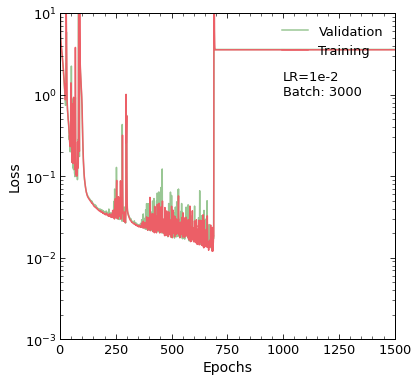

In [20]:
fig = plt.figure(figsize=(6,6))
plt.plot(history_ct.history['val_loss'], label="Validation")
plt.plot(history_ct.history['loss'], label="Training")
plt.yscale('log')
plt.ylim(.001,10)
plt.yticks(fontsize=13)
plt.xlim(0,1500)
plt.xticks(fontsize=13)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(loc='upper right', ncol=1)
plt.text(1000, 1.5, 'LR=1e-2', fontsize=13)
plt.text(1000, 1, 'Batch: 3000', fontsize=13)
# plt.tight_layout()
# plt.savefig('Regression_Plots/July/XY_STSC_lossCurves_3000batch_LR1e-2_2021-07-016.png', format='png')
plt.show()

### Predictions

In [21]:
preds = np.exp(pfn.predict(x_test, batch_size=3000).flatten())
print(preds.shape)

2021-07-18 12:10:19.816870: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:656] In AUTO-mode, and switching to DATA-based sharding, instead of FILE-based sharding as we cannot find appropriate reader dataset op(s) to shard. Error: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_246183"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.a

(26250,)


#### Histogram of Predictions

/usr/local/lib/python3.8/dist-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


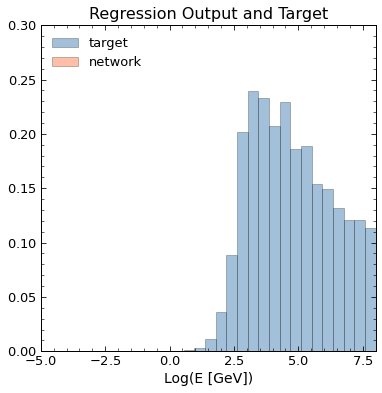

In [22]:
## PREDICTIONS AND TRUTH ##
bins = np.linspace(-4,8,30, endpoint=True)
fig = plt.figure(figsize=(6,6))
plt.hist(np.exp(y_test), color='steelblue', bins=bins, density=True, alpha=.5, edgecolor='black', label='target')
plt.hist(preds, color='coral', bins=bins, density=True, alpha=.5, edgecolor='black', label='network')
plt.title('Regression Output and Target', fontsize=16)
plt.xlabel('Log(E [GeV])', fontsize=14)
plt.xlim(-5,8)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(loc='upper left')
# plt.tight_layout()
# plt.savefig('Regression_Plots/July/XY_STSC_targetPreds_3000batch_LR1e-2_2021-07-016.png', format='png')
plt.show()

## Analytics

<Figure size 799.992x599.976 with 0 Axes>

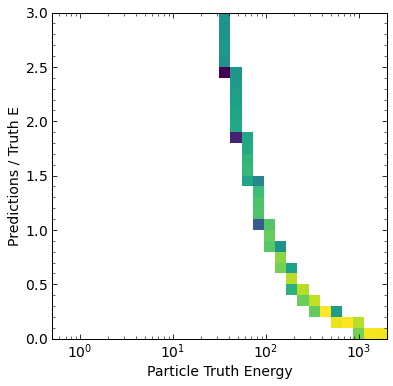

In [23]:
plt.cla(); plt.clf()

ybin = np.arange(0., 3.1, 0.1)
xbin = np.logspace(np.log10(.5), np.log10(2000), num=len(ybin), endpoint=True, base=10.0)

fig = plt.figure(figsize=(6,6))
fig.patch.set_facecolor('white')
plt.hist2d(np.exp(y_test), preds/np.exp(y_test), bins=[xbin,ybin], norm=LogNorm())
plt.xlabel('Particle Truth Energy', fontsize=14)
plt.ylabel('Predictions / Truth E', fontsize=14)
plt.xscale('log')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.tight_layout()
# plt.savefig('Regression_Plots/Clusters_and_Tracks_2021-06-30.png', format='png')
plt.show()

#### Response Plot

<Figure size 799.992x599.976 with 0 Axes>

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tex Gyre Heros, Helvetica, Nimbus Sans, FreeSans, Arial


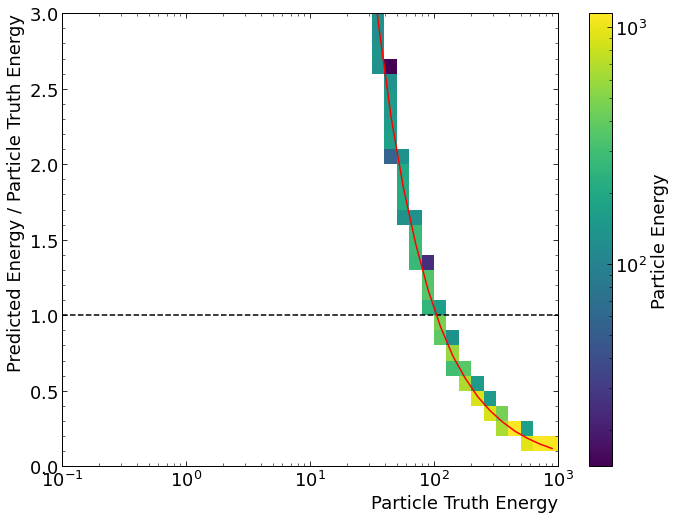

In [24]:
resplot = ru.responsePlot(x=np.exp(y_test), y=preds/np.exp(y_test),
                figfile='',
                statistic='median', xlabel='Particle Truth Energy', ylabel='Predicted Energy / Particle Truth Energy',
                atlas_x=-1, atlas_y=-1, simulation=True, cblabel='Particle Energy',
                textlist=[])
# Regression_Plots/July/XY_STSC_responsePlot_3000batch_LR1e-5_2021-07-015.png

#### Resolution Plot

<Figure size 799.992x599.976 with 0 Axes>

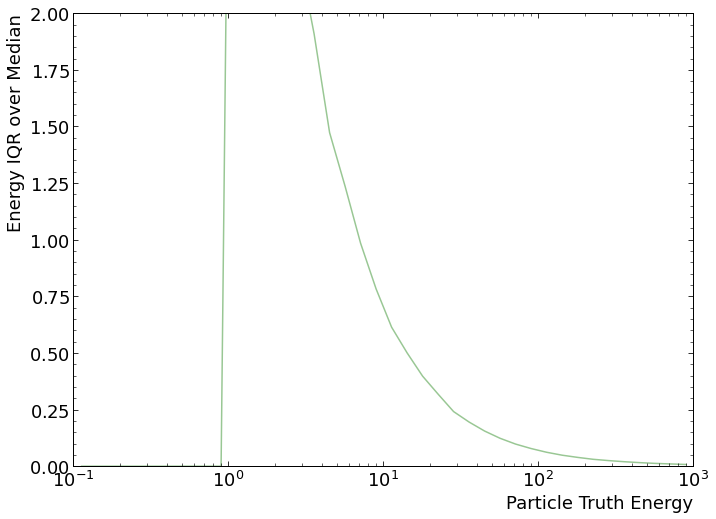

In [25]:
resp_plot = ru.resolutionPlot(x=np.exp(y_test), y=preds/np.exp(y_test),
                    figfile='',
                    statistic='std', xlabel='Particle Truth Energy', ylabel='Energy IQR over Median',
                    atlas_x=-1, atlas_y=-1, simulation=False,
                    textlist=[])
# Regression_Plots/July/XY_STSC_resolutionPlot_3000batch_LR1e-5_2021-07-015.png

# Cluster Only

In [211]:
dat = np.load('/fast_scratch/atlas_images/v01-45/XY_clustersOnly_med.npz')
print(dat.files)
X_clustOnly = dat['arr_0']
Y_clustOnly = dat['arr_1']
print(np.shape(X_clustOnly))
print(np.shape(Y_clustOnly))
N_events = len(X_clustOnly)

['arr_0', 'arr_1']
(68516, 929, 5)
(68516,)


### Visualize Input Data

(68516,)


<Figure size 799.992x599.976 with 0 Axes>

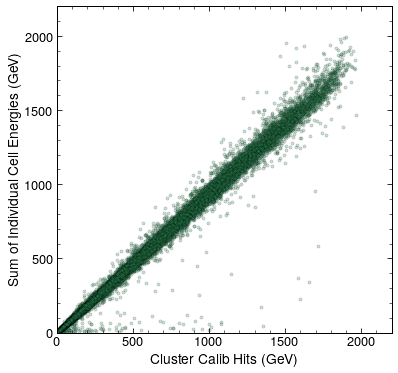

In [212]:
cluster_E_sum = np.sum(X_clustOnly[:,:,0], axis=1)
print(cluster_E_sum.shape)
plt.cla();plt.clf()
fig = plt.figure(figsize=(6,6))
fig.patch.set_facecolor(color='white')
plt.scatter(Y_clustOnly, cluster_E_sum, s=10,edgecolor='black', color='seagreen', alpha=.25)
plt.xlabel('Cluster Calib Hits (GeV)', fontsize=14)
plt.ylabel('Sum of Individual Cell Energies (GeV)', fontsize=14)
plt.xlim(0,2200)
plt.ylim(0,2200)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
# plt.tight_layout()
# plt.savefig('Regression_Plots/ClusterOnly_RegressionInputs_2021-06-09.png', format='png')
plt.show()

### Normalize Target

In [213]:
print(Y_clustOnly.shape)
Y_cO_mask = Y_clustOnly > .1
print('Any target values less than 100 MeV: '+repr(np.any(Y_cO_mask)))
nCData = np.count_nonzero(Y_cO_mask)
print('number after cut: '+str(nCData))

(68516,)
Any target values less than 100 MeV: True
number after cut: 63459


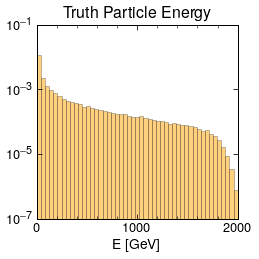

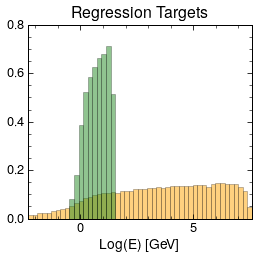

In [222]:
## RAW ##
#=====================================================
Y_cO = np.ndarray.copy(Y_clustOnly[Y_cO_mask])
#=====================================================


fig = plt.figure(figsize=(4,4))
bins=np.linspace(0,2000,50,endpoint=True)
plt.hist(Y_cO, color='orange', bins=bins, density=True, alpha=.5, edgecolor='black',
        label='raw regression target')
plt.title('Truth Particle Energy', fontsize=16)
plt.xlabel('E [GeV]', fontsize=14)
plt.xlim(np.min(bins),np.max(bins))
plt.yscale('log')
# plt.ylim(0,.55)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
# plt.tight_layout()
# plt.savefig('Regression_Plots/CLO_EnergyTargets_raw_2020-07-01.png', format='png')
plt.show()


## NORMALIZED ##
#=============================================
Y_nonzero = Y_cO != 0
Y_cO[Y_nonzero] = np.log(Y_cO[Y_nonzero])
Y_cON = np.ndarray.copy(Y_cO)
Y_cON[Y_nonzero] = Y_cON[Y_nonzero]/5
#==============================================


# print(Y_cOn.shape)
fig = plt.figure(figsize=(4,4))
bins=np.linspace(np.log(.1), np.log(2000), 50, endpoint=True)
plt.hist(Y_cO, color='orange', bins=bins, density=True, alpha=.5, edgecolor='black',
        label='log')
plt.hist(Y_cON, color='forestgreen', bins=bins, density=True, alpha=.5, edgecolor='black',
        label='scaled log')
plt.title('Regression Targets', fontsize=16)
plt.xlabel('Log(E) [GeV]', fontsize=14)
plt.xlim(np.min(bins),np.max(bins))
plt.ylim(0,.8)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
# plt.tight_layout()
# plt.savefig('Regression_Plots/CLO_EnergyTargets_normalization_2020-07-01.png', format='png')
plt.show()

### Data Normalization

In [215]:
## DEEP COPY ARRAY ##
X_cO = np.ndarray.copy(X_clustOnly[Y_cO_mask,:,0:4])
X_cO_norm = np.ndarray.copy(X_clustOnly[Y_cO_mask,:,0:4])
print(X_cO.shape)

(63459, 929, 4)


In [216]:
## Normalize rPerp to 1/1000
rPerp_mask = X_cO[:,:,3] != 0
X_cO[:,:,3][rPerp_mask] = X_cO[:,:,3][rPerp_mask]/1000.

## Energy Values that are not zero!
E_nonZeroMask = X_cO[:,:,0] != 0
X_cO[:,:,0][E_nonZeroMask] = np.log(X_cO[:,:,0][E_nonZeroMask])

## Eta and Phi
# do nothing for now as a control and check performance
eta_mask = X_cO[:,:,1] != 0
X_cO[:,:,1][eta_mask] = X_cO[:,:,1][eta_mask]

phi_mask = X_cO[:,:,2] != 0
X_cO[:,:,2][phi_mask] = X_cO[:,:,2][phi_mask]

#### New Normalization Scheme

In [217]:
## Normalize rPerp to between 0 and 1
rPerp_maskn = X_cO_norm[:,:,3] != 0
X_cO_norm[:,:,3] = X_cO_norm[:,:,3]/3630.

## Energy Values that are not zero!
E_nonZeroMaskn = X_cO_norm[:,:,0] != 0
X_cO_norm[:,:,0][E_nonZeroMaskn] = np.log(X_cO_norm[:,:,0][E_nonZeroMaskn])
cellE_mean = np.mean(X_cO_norm[:,:,0][E_nonZeroMaskn])
cellE_std = np.std(X_cO_norm[:,:,0][E_nonZeroMaskn])
X_cO_norm[:,:,0][E_nonZeroMaskn] = (X_cO_norm[:,:,0][E_nonZeroMaskn] - cellE_mean)/cellE_std

## Eta and Phi
# normalize these values between 0 and 1 easily
eta_maskn = X_cO_norm[:,:,1] != 0
X_cO_norm[:,:,1][eta_maskn] = X_cO_norm[:,:,1][eta_maskn]/.7

phi_maskn = X_cO_norm[:,:,2] != 0
cellPhi_std = np.std(X_cO_norm[:,:,2][phi_maskn])
X_cO_norm[:,:,2][phi_maskn] = X_cO_norm[:,:,2][phi_maskn]/cellPhi_std

### Histograms of Inputs

<Figure size 799.992x599.976 with 0 Axes>

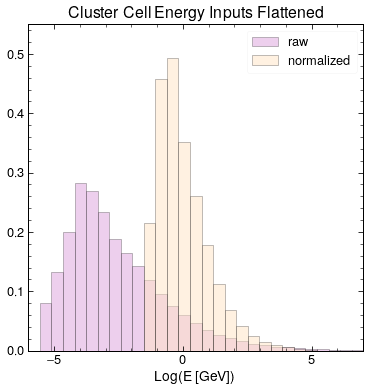

<Figure size 799.992x599.976 with 0 Axes>

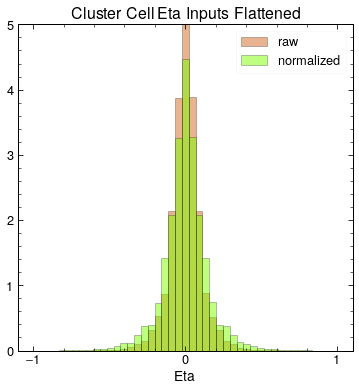

<Figure size 799.992x599.976 with 0 Axes>

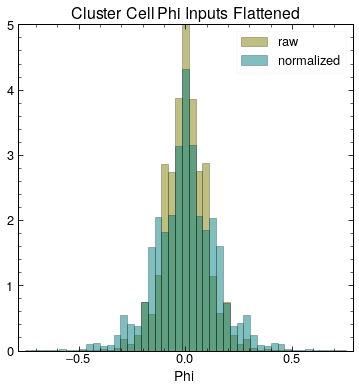

<Figure size 799.992x599.976 with 0 Axes>

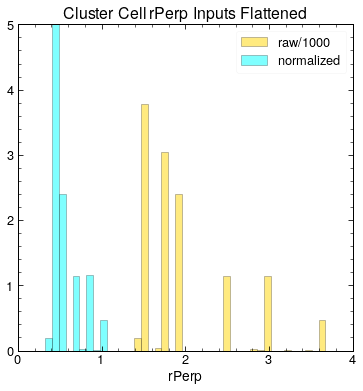

In [218]:
############
## ENERGY ##
############
plt.cla(); plt.clf()
fig = plt.figure(figsize=(6,6))
ebins = np.linspace(-6,7, 30, endpoint=True)
plt.hist(X_cO[:,:,0][E_nonZeroMask], color='plum', bins=ebins, density=True, alpha=.5, edgecolor='black',
         label='raw')
plt.hist(X_cO_norm[:,:,0][E_nonZeroMaskn], color='bisque', bins=ebins, density=True, alpha=.5, edgecolor='black',
         label='normalized')
plt.title('Cluster Cell Energy Inputs Flattened', fontsize=16)
plt.xlabel('Log(E [GeV])', fontsize=14)
plt.xlim(np.min(ebins),np.max(ebins))
plt.ylim(0,.55)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(loc='upper right')
# plt.tight_layout()
# plt.savefig('Regression_Plots/CLO_EnergyInputs_normalization_2020-07-01.png', format='png')
plt.show()

#########
## ETA ##
#########
plt.cla(); plt.clf()
fig = plt.figure(figsize=(6,6))
etabins = np.linspace(-1.1,1.1,50, endpoint=True)
plt.hist(X_cO[:,:,1][eta_mask], color='chocolate', bins=etabins, density=True, alpha=.5, edgecolor='black',
         label='raw')
plt.hist(X_cO_norm[:,:,1][eta_maskn], color='chartreuse', bins=etabins, density=True, alpha=.5, edgecolor='black',
         label='normalized')
plt.title('Cluster Cell Eta Inputs Flattened', fontsize=16)
plt.xlabel('Eta', fontsize=14)
plt.xlim(np.min(etabins),np.max(etabins))
plt.ylim(0,5)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(loc='upper right')
# plt.tight_layout()
# plt.savefig('Regression_Plots/CLO_EtaInputs_normalization_2020-07-01.png', format='png')
plt.show()

#########
## PHI ##
#########
plt.cla(); plt.clf()
fig = plt.figure(figsize=(6,6))
phibins = np.linspace(-np.pi/4,np.pi/4,50, endpoint=True)
plt.hist(X_cO[:,:,2][phi_mask], color='olive', bins=phibins, density=True, alpha=.5, edgecolor='black',
         label='raw')
plt.hist(X_cO_norm[:,:,2][phi_maskn], color='teal', bins=phibins, density=True, alpha=.5, edgecolor='black',
         label='normalized')
plt.title('Cluster Cell Phi Inputs Flattened', fontsize=16)
plt.xlabel('Phi', fontsize=14)
plt.xlim(np.min(phibins),np.max(phibins))
plt.ylim(0,5)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(loc='upper right')
# plt.tight_layout()
# plt.savefig('Regression_Plots/CLO_PhiInputs_normalization_2020-07-01.png', format='png')
plt.show()

###########
## RPERP ##
###########
plt.cla(); plt.clf()
fig = plt.figure(figsize=(6,6))
Rbins = np.linspace(-0,4,50, endpoint=True)
plt.hist(X_cO[:,:,3][rPerp_mask], color='gold', bins=Rbins, density=True, alpha=.5, edgecolor='black',
         label='raw/1000')
plt.hist(X_cO_norm[:,:,3][rPerp_maskn], color='aqua', bins=Rbins, density=True, alpha=.5, edgecolor='black',
         label='normalized')
plt.title('Cluster Cell rPerp Inputs Flattened', fontsize=16)
plt.xlabel('rPerp', fontsize=14)
plt.xlim(np.min(Rbins),np.max(Rbins))
plt.ylim(0,5)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(loc='upper right')
# plt.tight_layout()
# plt.savefig('Regression_Plots/CLO_rPerpInputs_normalization_2020-07-01.png', format='png')
plt.show()


## Model Building & Settings

In [219]:
# EFN regression example uses 75/10/15 split for 100,000 samples
c_train, c_val, c_test = tvt_num(X_cO, _tvt=(75, 10, 15))
print('train -- val -- test')
print(str(c_train)+' -- '+str(c_val)+' -- '+str(c_test))

# network architecture parameters
Phi_sizes, F_sizes = (100, 100, 128), (100, 100, 100)
output_act, output_dim = 'linear', 1
loss = 'mse'

# network training parameters
num_epoch = 60
batch_size = 50

train -- val -- test
47594 -- 6346 -- 9519


#### TVT Split

In [220]:
print('Totals for inputs')
print(X_cO.shape)
print(Y_cO.shape);print()
(cl_train, cl_val, cl_test,
 y_cl_train, y_cl_val, y_cl_test) = ef.utils.data_split(X_cO, Y_cO, val=c_val, test=c_test)
(cln_train, cln_val, cln_test,
 y_cln_train, y_cln_val, y_cln_test) = ef.utils.data_split(X_cO_norm, Y_cON, val=c_val, test=c_test)

print('Totals for training data')
print(np.shape(cl_train))
print(np.shape(y_cl_train))

Totals for inputs
(63459, 929, 4)
(63459,)

Totals for training data
(47594, 929, 4)
(47594,)


#### Build Model

In [102]:
pfnC = PFN(input_dim=4, Phi_sizes=Phi_sizes, F_sizes=F_sizes, 
          output_act=output_act, output_dim=output_dim, loss=loss, metrics=[])

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_21 (Activation)      (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_21[0][0]              
____________________________________________________________________________________________

## Train Single Model, no loop

In [103]:
history = pfnC.fit(cl_train, y_cl_train,
        epochs=num_epoch,
        batch_size=batch_size,
        validation_data=(cl_val, y_cl_val),
        verbose=1)

Epoch 1/60
952/952 [==============================] - 6s 5ms/step - loss: 1067.5279 - val_loss: 2.5217
Epoch 2/60
952/952 [==============================] - 4s 5ms/step - loss: 6.6905 - val_loss: 3.5111
Epoch 3/60
952/952 [==============================] - 5s 5ms/step - loss: 2.6180 - val_loss: 4.1009
Epoch 4/60
952/952 [==============================] - 4s 5ms/step - loss: 2.3990 - val_loss: 2.2718
Epoch 5/60
952/952 [==============================] - 4s 5ms/step - loss: 2.7801 - val_loss: 1.4829
Epoch 6/60
952/952 [==============================] - 4s 5ms/step - loss: 4.1261 - val_loss: 1.3678
Epoch 7/60
952/952 [==============================] - 4s 5ms/step - loss: 1.4757 - val_loss: 1.4028
Epoch 8/60
952/952 [==============================] - 4s 5ms/step - loss: 1.0971 - val_loss: 1.4533
Epoch 9/60
952/952 [==============================] - 4s 5ms/step - loss: 1.1373 - val_loss: 0.3705
Epoch 10/60
952/952 [==============================] - 5s 5ms/step - loss: 0.3810 - val_loss: 0.2

#### Train Model in Loop

In [221]:
history_list_raw = []
history_list_norm = []
prediction_list_raw = []
prediction_list_norm = []

for i in range(5):
    print();print();print('BUILDING MODEL '+str(i)+' RAW');print();print()
    raw_model = PFN(input_dim=4, Phi_sizes=Phi_sizes, F_sizes=F_sizes, 
          output_act=output_act, output_dim=output_dim, loss=loss, metrics=[])
    print();print();print('TRAINING MODEL '+str(i)+' RAW');print();print()
    my_history_raw = raw_model.fit(cl_train, y_cl_train,
        epochs=num_epoch,
        batch_size=batch_size,
        validation_data=(cl_val, y_cl_val),
        verbose=1)
    history_list_raw.append(my_history_raw)
    raw_preds = raw_model.predict(cl_test, batch_size=50)
    prediction_list_raw.append((raw_preds, y_cl_test))
    
    print();print();print('BUILDING MODEL '+str(i)+' NORMALIZED');print();print()
    norm_model = PFN(input_dim=4, Phi_sizes=Phi_sizes, F_sizes=F_sizes, 
          output_act=output_act, output_dim=output_dim, loss=loss, metrics=[])
    print();print();print('TRAINING MODEL '+str(i)+' NORMALIZED');print();print()
    my_history_norm = norm_model.fit(cln_train, y_cln_train,
        epochs=num_epoch,
        batch_size=batch_size,
        validation_data=(cln_val, y_cln_val),
        verbose=1)
    history_list_norm.append(my_history_norm)
    norm_preds = norm_model.predict(cln_test, batch_size=50)
    prediction_list_norm.append((norm_preds, y_cln_test))



BUILDING MODEL 0 RAW


Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_105 (Activation)     (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_105[0][0]             
__________________________________________________________________

<Figure size 799.992x599.976 with 0 Axes>

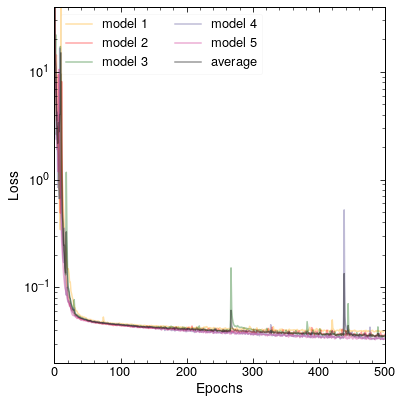

<Figure size 799.992x599.976 with 0 Axes>

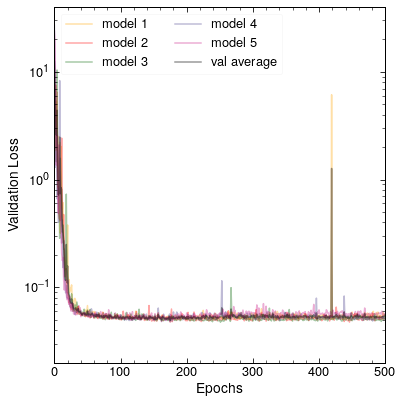

<Figure size 799.992x599.976 with 0 Axes>

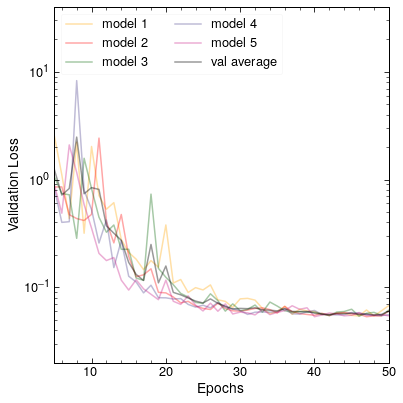

In [72]:
plt.cla(); plt.clf()
colors1 = ['orange', 'red', 'darkgreen', 'darkslateblue', 'mediumvioletred']
colors2 = ['chocolate', 'olivedrab', 'steelblue', 'seagreen', 'indigo']
model_num = ['1','2','3','4','5']

loss_av = np.zeros(np.shape(history_list[0].history['loss']))
fig = plt.figure(figsize=(6,6))
for i in range(5):
    plt.plot(history_list[i].history['loss'], color=colors1[i], alpha=.35,
            label='model '+model_num[i])
    loss_av = np.add(loss_av, history_list[i].history['loss'])
loss_av = loss_av/5
plt.plot(loss_av, color='black', alpha=.4, label='average')
plt.yscale('log')
plt.ylim(.02,40)
plt.yticks(fontsize=13)
plt.xlim(0,500)
plt.xticks(fontsize=13)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(loc='upper left', ncol=2)
# plt.tight_layout()
# plt.savefig('Regression_Plots/clusterOnly_losses_5runs_500epoch_50batch_2021-06-18.png', format='png')
plt.show()

plt.cla(); plt.clf()
val_loss_av = np.zeros(np.shape(history_list[0].history['val_loss']))
fig = plt.figure(figsize=(6,6))
for i in range(5):
    plt.plot(history_list[i].history['val_loss'], color=colors1[i], alpha=.35,
            label='model '+model_num[i])
    val_loss_av = np.add(val_loss_av, history_list[i].history['val_loss'])
val_loss_av = val_loss_av/5
plt.plot(val_loss_av, color='black', alpha=.4, label='val average')
plt.yscale('log')
plt.ylim(.02,40)
plt.yticks(fontsize=13)
plt.xlim(0,500)
plt.xticks(fontsize=13)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Validation Loss', fontsize=14)
plt.legend(loc='upper left', ncol=2)
# plt.tight_layout()
# plt.savefig('Regression_Plots/clusterOnly_val_losses_5runs_500epoch_50batch_2021-06-18.png', format='png')
plt.show()

plt.cla(); plt.clf()
val_loss_av = np.zeros(np.shape(history_list[0].history['val_loss']))
fig = plt.figure(figsize=(6,6))
for i in range(5):
    plt.plot(history_list[i].history['val_loss'], color=colors1[i], alpha=.35,
            label='model '+model_num[i])
    val_loss_av = np.add(val_loss_av, history_list[i].history['val_loss'])
val_loss_av = val_loss_av/5
plt.plot(val_loss_av, color='black', alpha=.4, label='val average')
plt.yscale('log')
plt.ylim(.02,40)
plt.yticks(fontsize=13)
plt.xlim(5,50)
plt.xticks(fontsize=13)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Validation Loss', fontsize=14)
plt.legend(loc='upper left', ncol=2)
# plt.tight_layout()
# plt.savefig('Regression_Plots/clusterOnly_val_losses_5runs_500epoch_50batch_zoomed_2021-06-18.png', format='png')
plt.show()

#### Average Loss Comparison

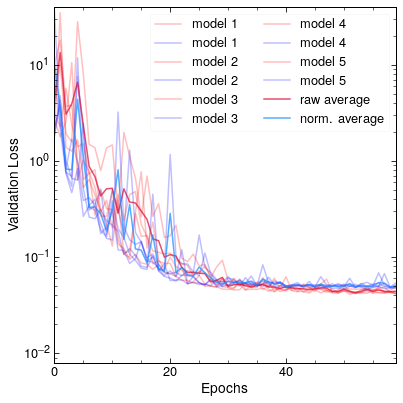

In [201]:
val_loss_av_raw = np.zeros(np.shape(history_list_raw[0].history['val_loss']))
val_loss_av_norm = np.zeros(np.shape(history_list_norm[0].history['val_loss']))
fig = plt.figure(figsize=(6,6))

for i in range(5):
    plt.plot(history_list_raw[i].history['val_loss'], color='red', alpha=.25,
            label='model '+str(i+1))
    plt.plot(history_list_norm[i].history['val_loss'], color='blue', alpha=.25,
            label='model '+str(i+1))
    val_loss_av_raw = np.add(val_loss_av_raw, history_list_raw[i].history['val_loss'])
    val_loss_av_norm = np.add(val_loss_av_norm, history_list_norm[i].history['val_loss'])
val_loss_av_raw = val_loss_av_raw/5
val_loss_av_norm = val_loss_av_norm/5
plt.plot(val_loss_av_raw, color='crimson', alpha=.75, label='raw average')
plt.plot(val_loss_av_norm, color='dodgerblue', alpha=.75, label='norm. average')
plt.yscale('log')
plt.ylim(.008,40)
plt.yticks(fontsize=13)
plt.xlim(0,59)
plt.xticks(fontsize=13)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Validation Loss', fontsize=14)
plt.legend(loc='upper right', ncol=2)
# plt.tight_layout()
# plt.savefig('Regression_Plots/clusterOnly_val_losses_5runs_60epoch_50batch_normVsRaw_2021-07-01.png', format='png')
plt.show()

#### Median Statistic Comparison

In [173]:
from scipy import stats

In [194]:
# history_list_raw = []
# history_list_norm = []
# prediction_list_raw = []
# prediction_list_norm = []

ybin = np.arange(0., 3.1, 0.1)
xbin = np.logspace(np.log10(.5), np.log10(2000), num=len(ybin), endpoint=True, base=10.0)
xcenter = [(xbin[i] + xbin[i+1]) / 2. for i in range(len(xbin)-1)]

normalized_median = np.zeros(len(ybin)-1)
raw_median = np.zeros(len(ybin)-1)

for i in range(5):
    # raw
    #===============================================
    preds_raw, target_raw = prediction_list_raw[i]
    preds_raw = np.exp(preds_raw.flatten())
    target_raw = np.exp(target_raw)
    median_binstat = stats.binned_statistic(target_raw, preds_raw/target_raw, statistic='mean',
                                           bins=xbin).statistic
    raw_median = raw_median + median_binstat

    # normalized
    #===============================================
    preds_norm, target_norm = prediction_list_norm[i]
    preds_norm = np.exp(preds_norm.flatten())
    target_norm = np.exp(target_norm)
    median_binstat = stats.binned_statistic(target_norm, preds_norm/target_norm, statistic='mean',
                                           bins=xbin).statistic
    normalized_median = normalized_median + median_binstat

normalized_median = normalized_median/5
raw_median = raw_median/5

<Figure size 799.992x599.976 with 0 Axes>

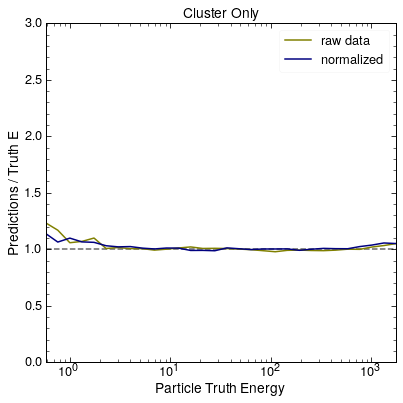

In [200]:
plt.cla();plt.clf()
fig=plt.figure(figsize=(6,6))
plt.plot([np.min(xcenter), np.max(xcenter)], [1, 1], linestyle='--', color='black', alpha=.6, label=None)
plt.plot(xcenter, raw_median, label='raw data', color='olive')
plt.plot(xcenter, normalized_median, label='normalized', color='navy')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xscale('log')
plt.xlim(np.min(xcenter), np.max(xcenter))
plt.ylim(0,3)
plt.title('Cluster Only', fontsize=14)
plt.xlabel('Particle Truth Energy', fontsize=14)
plt.ylabel('Predictions / Truth E', fontsize=14)
plt.legend(loc='upper right')
# plt.tight_layout()
# plt.savefig('Regression_Plots/clusterOnly_raw_vs_norm_comparison_2021-07-01.png', format='png')
plt.show()

### Predictions

In [104]:
cl_preds = pfnC.predict(cl_test, batch_size=50)
print(cl_test.shape)
print(cl_preds.shape)

(9519, 929, 4)
(9519, 1)


#### Plot Inputs and Target

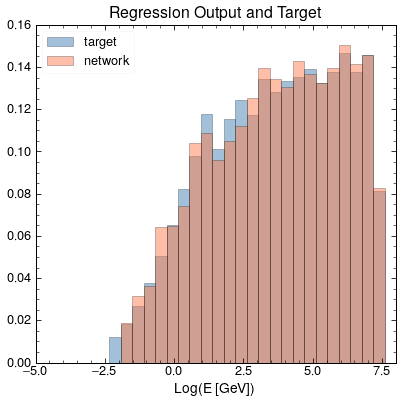

In [108]:
## PREDICTIONS AND TRUTH ##
bins = np.linspace(-4,8,30, endpoint=True)
fig = plt.figure(figsize=(6,6))
plt.hist(y_cl_test, color='steelblue', bins=bins, density=True, alpha=.5, edgecolor='black', label='target')
plt.hist(cl_preds, color='coral', bins=bins, density=True, alpha=.5, edgecolor='black', label='network')
plt.title('Regression Output and Target', fontsize=16)
plt.xlabel('Log(E [GeV])', fontsize=14)
plt.xlim(-5,8)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(loc='upper left')
# plt.tight_layout()
# plt.savefig('Regression_Plots/clusterOnly-output-wTarget-regression-log_2021-06-29.png', format='png')
plt.show()

### Analytics

#### Loss

dict_keys(['loss', 'val_loss'])


<Figure size 799.992x599.976 with 0 Axes>

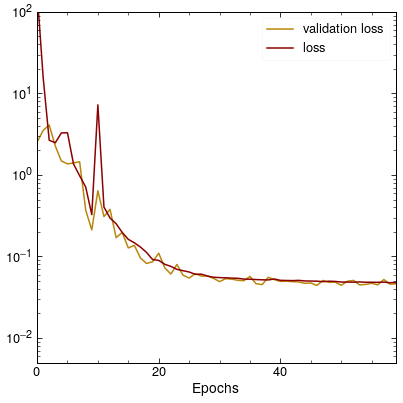

In [109]:
print(history.history.keys())
plt.cla(); plt.clf()
fig = plt.figure(figsize=(6,6))
plt.plot(history.history['val_loss'], color='darkgoldenrod', label='validation loss')
plt.plot(history.history['loss'], color='darkred', label='loss')
plt.yscale('log')
plt.ylim(.005,1e2)
plt.yticks(fontsize=13)
plt.xlim(0,59)
plt.xticks(fontsize=13)
plt.xlabel('Epochs', fontsize=14)
plt.legend(loc='upper right')
# plt.tight_layout()
# plt.savefig('Regression_Plots/clusterOnly_losses_log_2021-06-29.png', format='png')
plt.show()

#### 2-D Histogram

(9519,)
(9519, 1)
(9519,) (9519,)


<Figure size 799.992x599.976 with 0 Axes>

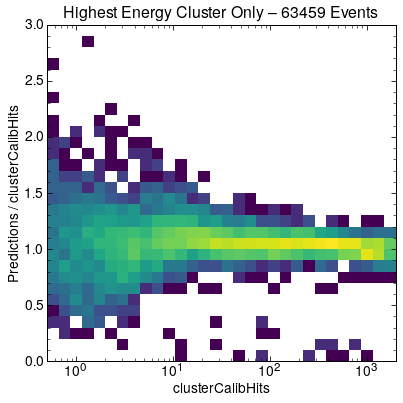

In [110]:
print(y_cl_test.shape)
print(cl_preds.shape)
clusterHits = np.exp(y_cl_test.flatten())
networkPreds = np.exp(cl_preds.flatten())
print(repr(clusterHits.shape)+' '+repr(networkPreds.shape))

ybin = np.arange(0., 3.1, 0.1)
xbin = np.logspace(np.log10(.5), np.log10(2000), num=len(ybin), endpoint=True, base=10.0)

plt.cla(); plt.clf()
fig = plt.figure(figsize=(6,6))
fig.patch.set_facecolor('white')
plt.hist2d(clusterHits, networkPreds/clusterHits, bins=[xbin,ybin], norm=LogNorm())
plt.title('Highest Energy Cluster Only -- 63459 Events', fontsize=16)
plt.xlabel('clusterCalibHits', fontsize=14)
plt.ylabel('Predictions / clusterCalibHits', fontsize=14)
plt.xscale('log')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.tight_layout()
# plt.savefig('Regression_Plots/SingleCluster_regression_gt_pt1GeV_log_normal_training_2021-06-29.png', format='png')
plt.show()

#### Resolution Plots

<Figure size 799.992x599.976 with 0 Axes>

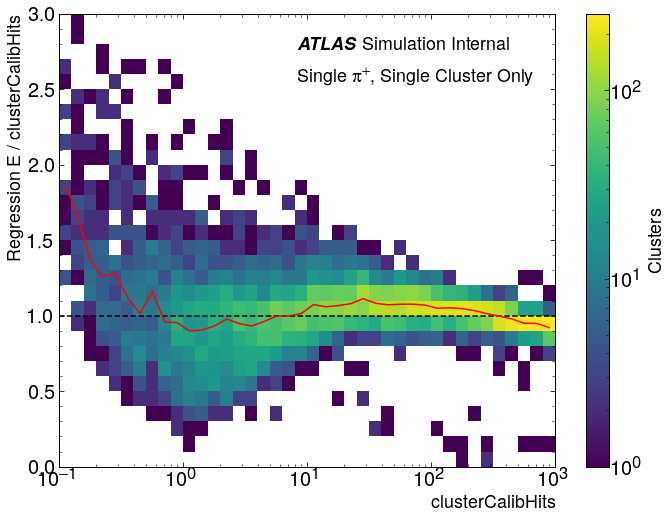

In [102]:
plotpath = '/home/russbate/MLPionCollaboration/LCStudies/clusters/Regression_Plots/'
Pt_center, Pt_Single = ru.responsePlot(clusterHits, 
                      networkPreds/clusterHits,
                      figfile = plotpath+'singleCluster_responsePlot_2021-06-18.png', statistic = 'median',
                      xlabel = 'clusterCalibHits', ylabel = 'Regression E / clusterCalibHits',
                      atlas_x = 0.48, atlas_y = 0.95, simulation = True,
                      textlist = [{'x': 0.48, 'y': 0.85, 'text': 'Single $\pi^{+}$, Single Cluster Only'}])

#### Scatter Plot

<Figure size 799.992x599.976 with 0 Axes>

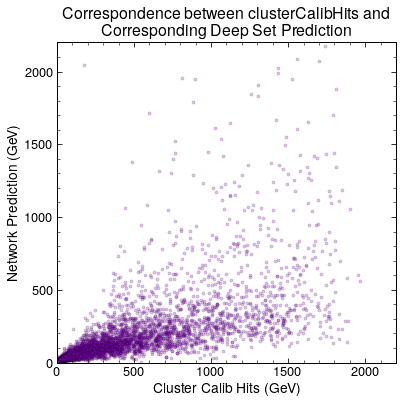

In [66]:
plt.cla();plt.clf()

fig = plt.figure(figsize=(6,6))
fig.patch.set_facecolor(color='white')
plt.scatter(clusterHits, networkPreds, s=10, edgecolor='black', color='darkviolet', alpha=.25)
plt.title('Correspondence between clusterCalibHits and\n Corresponding Deep Set Prediction',
         fontsize=16)
plt.xlabel('Cluster Calib Hits (GeV)', fontsize=14)
plt.ylabel('Network Prediction (GeV)', fontsize=14)
plt.xlim(0,2200)
plt.ylim(0,2200)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
# plt.tight_layout()
# plt.savefig('Regression_Plots/ClusterOnly_NetworkPredictions_scatter_Log_better_2021-06-10.png', format='png')
plt.show()

## Track Only

In [14]:
dat = np.load('/fast_scratch/atlas_images/v01-45/XY_tracksOnly_Pt_distributed_med.npz')
print(dat.files)
X_tracksOnly = dat['arr_0']
Y_tracksOnly = dat['arr_1']
print(np.shape(X_tracksOnly))
print(np.shape(Y_tracksOnly))
N_events = len(X_tracksOnly)

['arr_0', 'arr_1']
(69414, 6, 5)
(69414,)


### Data Normalization

In [15]:
t_Pt = X_tracksOnly[:,:,0]
t_Eta = np.atleast_3d(X_tracksOnly[:,:,1])
t_Phi = np.atleast_3d(X_tracksOnly[:,:,2])
t_rPerp = X_tracksOnly[:,:,3]

Y_trthPt = Y_tracksOnly

#### Energy

In [16]:
# this ensures we dont run into a runtime warning and zeros stay zeros when taking log
Pt_mask = t_Pt > 0
t_Pt[Pt_mask] = np.log(t_Pt[Pt_mask])
t_Pt = np.atleast_3d(t_Pt)
print(t_Pt.shape)

(69414, 6, 1)


#### rPerp

In [17]:
t_rPerp = np.atleast_3d(t_rPerp/1000)
print(t_rPerp.shape)

(22339, 1017, 1)


#### Target

In [190]:
# this ensures we dont run into a runtime warning and zeros stay zeros when taking log
Y_Pt_mask = Y_trthPt > 0
Y_trthPt[Y_Pt_mask] = np.log(Y_trthPt[Y_Pt_mask])
print('Zero Pt found: '+repr(np.any(Y_Pt_mask)))
# Y_trthPt = np.atleast_2d(Y_trthPt).transpose()
print(Y_trthPt.shape)

Zero Pt found: True
(69414,)


#### Track Deep Set

In [19]:
XtO_deep = np.concatenate((t_Pt, t_Eta, t_Phi, t_rPerp), axis=2)
print(XtO_deep.shape)

(69414, 6, 4)


### Model Settings

In [20]:
# EFN regression example uses 75/10/15 split for 100,000 samples
t_train, t_val, t_test = tvt_num(XtO_deep, _tvt=(75, 10, 15))
print('train -- val -- test')
print(str(t_train)+' -- '+str(t_val)+' -- '+str(t_test))

# network architecture parameters
Phi_sizes, F_sizes = (100, 100, 128), (100, 100, 100)
output_act, output_dim = 'linear', 1
loss = 'mse'

# network training parameters
num_epoch = 100
batch_size = 600

train -- val -- test
52060 -- 6941 -- 10413


#### TVT Split

In [21]:
(t_train, t_val, t_test,
 y_pt_train, y_pt_val, y_pt_test) = ef.utils.data_split(XtO_deep, Y_trthPt, val=t_val, test=t_test)

# Print out tensor shapes
print(np.shape(t_train))
print(np.shape(y_pt_train))

(52060, 6, 4)
(52060,)


### Build Architecture

In [22]:
pfnT = PFN(input_dim=4, Phi_sizes=Phi_sizes, F_sizes=F_sizes, 
          output_act=output_act, output_dim=output_dim, loss=loss, metrics=[])

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_7 (Activation)       (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_7[0][0]               
____________________________________________________________________________________________

### Train Model

In [23]:
pfnT.fit(t_train, y_pt_train,
        epochs=num_epoch,
        batch_size=batch_size,
        validation_data=(t_val, y_pt_val),
        verbose=1)

Epoch 1/100
87/87 [==============================] - 6s 11ms/step - loss: 19.7431 - val_loss: 0.1761
Epoch 2/100
87/87 [==============================] - 0s 4ms/step - loss: 0.1284 - val_loss: 0.1257
Epoch 3/100
87/87 [==============================] - 0s 5ms/step - loss: 0.0931 - val_loss: 0.1188
Epoch 4/100
87/87 [==============================] - 0s 5ms/step - loss: 0.0851 - val_loss: 0.1037
Epoch 5/100
87/87 [==============================] - 0s 5ms/step - loss: 0.0801 - val_loss: 0.1044
Epoch 6/100
87/87 [==============================] - 0s 5ms/step - loss: 0.0759 - val_loss: 0.0990
Epoch 7/100
87/87 [==============================] - 0s 5ms/step - loss: 0.0775 - val_loss: 0.0977
Epoch 8/100
87/87 [==============================] - 0s 5ms/step - loss: 0.0845 - val_loss: 0.0950
Epoch 9/100
87/87 [==============================] - 0s 5ms/step - loss: 0.0773 - val_loss: 0.0955
Epoch 10/100
87/87 [==============================] - 0s 5ms/step - loss: 0.0830 - val_loss: 0.0934
Epoch 1

#### Predictions

(10413, 1)


<Figure size 799.992x599.976 with 0 Axes>

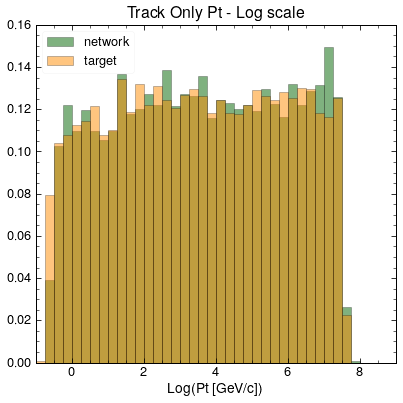

In [179]:
t_preds = pfnT.predict(t_test, batch_size=1000)
print(t_preds.shape)
bins = np.arange(-1,8.25,.25)

plt.cla(); plt.clf()
fig = plt.figure(figsize=(6,6))
fig.patch.set_facecolor('white')
plt.hist(t_preds.flatten(), bins=bins, density=True, color='darkgreen', alpha=.5, edgecolor='black', label='network')
plt.hist(y_pt_test, bins=bins, density=True, color='darkorange', alpha=.5, edgecolor='black', label='target')
plt.title('Track Only Pt - Log scale', fontsize=16)
plt.xlabel('Log(Pt [GeV/c])', fontsize=14)
plt.xlim(-1,9)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(loc='upper left')
# plt.tight_layout()
# plt.savefig('Regression_Plots/Inputs-and-outputs-to-trackPt-regression-log_2021-06-10.png', format='png')
plt.show()

### Analytics

<Figure size 799.992x599.976 with 0 Axes>

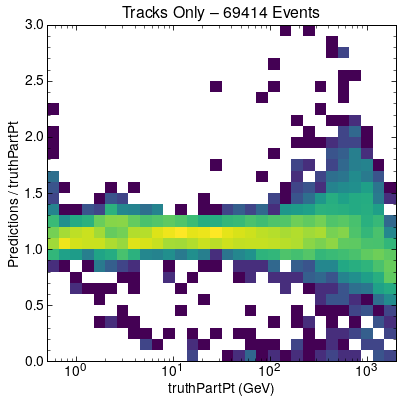

In [36]:
pt_pred = np.exp(t_preds.flatten())
pt_trth = np.exp(y_pt_test.flatten())

ybin = np.arange(0., 3.1, 0.1)
xbin = np.logspace(np.log10(.5), np.log10(2000), num=len(ybin), endpoint=True, base=10.0)

plt.cla(); plt.clf()
fig = plt.figure(figsize=(6,6))
fig.patch.set_facecolor('white')
plt.hist2d(pt_trth, pt_pred/pt_trth, bins=[xbin,ybin], norm=LogNorm())
plt.title('Tracks Only -- 69414 Events', fontsize=16)
plt.xlabel('truthPartPt (GeV)', fontsize=14)
plt.ylabel('Predictions / truthPartPt', fontsize=14)
plt.xscale('log')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.tight_layout()
# plt.savefig('Regression_Plots/Pt_TrackOnly_mediumRoot_2021-06-08.png', format='png')
plt.show()

In [202]:
tr_Pt_test = t_test[:,:,0].astype(np.float128)
tr_Pt_mask = tr_Pt_test != 0

print(repr(tr_Pt_test.shape)+' '+repr(tr_Pt_mask.shape))
tr_Pt_test[trck_tst_mask] = np.exp(tr_Pt_test[trck_tst_mask])

tr_Pt_test = np.sum(tr_Pt_test, axis=1)
print(tr_Pt_test.shape)

(10413, 6) (10413, 6)
(10413,)


<ipython-input-202-f82aab97ac96>:5: RuntimeWarning: overflow encountered in exp
  tr_Pt_test[trck_tst_mask] = np.exp(tr_Pt_test[trck_tst_mask])


#### Response Plots

<Figure size 799.992x599.976 with 0 Axes>

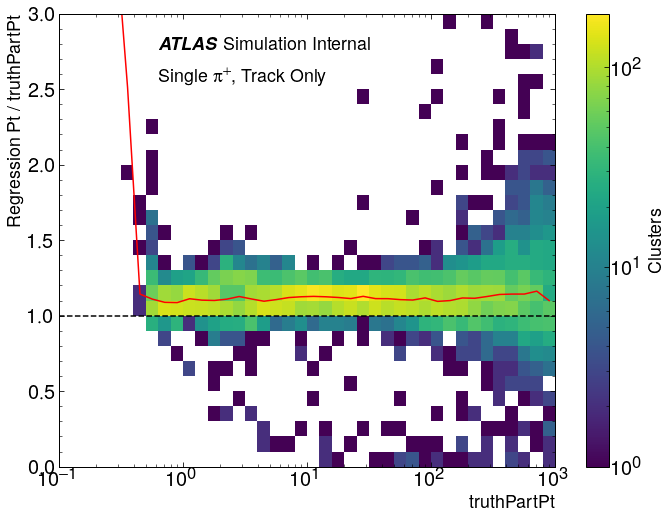

In [189]:
plotpath = '/home/russbate/MLPionCollaboration/LCStudies/clusters/Regression_Plots/'
Pt_center, Pt_Single = ru.responsePlot(pt_trth, 
                      pt_pred/pt_trth,
                      figfile = plotpath+'singleTrack_Pt_responsePlot.png', statistic = 'median',
                      xlabel = 'truthPartPt', ylabel = 'Regression Pt / truthPartPt',
                      atlas_x = 0.2, atlas_y = 0.95, simulation = True,
                      textlist = [{'x': 0.2, 'y': 0.85, 'text': 'Single $\pi^{+}$, Track Only'}])

In [ ]:
pu.lineOverlay(xcenter=xcenter, lines = [medBase, medSingleBase, medReg, medRegSingle],
                labels = ['EM Scale, All Clusters', 'EM Scale, Single Clusters', 'Regressed, All Clusters', 'Regressed, Single Clusters'],
                xlabel = 'Cluster Calib Hits', ylabel = 'Cluster Energy / Calib Hits',
                figfile = plotpath + "hist_2D_calib_vs_ratio_pp_profile_Overlay_BaseRegSingle.pdf",
                extra_lines = [[[0.1,1000],[1,1]]],
                atlas_x = 0.5, atlas_y = 0.3, simulation = True,
                textlist = [{'x': 0.5, 'y': 0.2, 'text': 'Single $\pi^{+}$'},
                                  {'x': 0.5, 'y': 0.15,  'text': 'Baseline 1-input Regression'},
                                  {'x': 0.5, 'y': 0.1, 'text': 'Trained on All Clusters'}])

## Energy Target Plots

<Figure size 799.992x599.976 with 0 Axes>

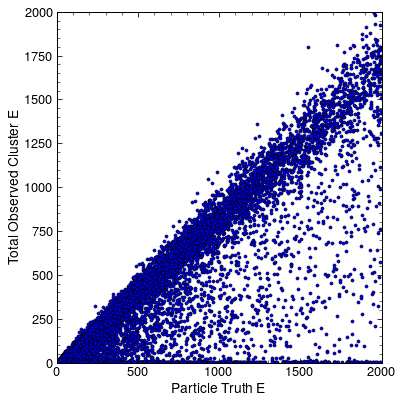

In [28]:
plt.cla(); plt.clf()
fig = plt.figure(figsize=(6,6))
fig.patch.set_facecolor('white')
plt.scatter(Y_truth, Y_clusterE, s=10,edgecolor='black', color='blue')
plt.xlabel('Particle Truth E', fontsize=14)
plt.ylabel('Total Observed Cluster E', fontsize=14)
# plt.title('truthPartE Against Observed Total', fontsize=18)
plt.xlim(0,2000)
plt.ylim(0,2000)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()
plt.savefig('Plots/truthPartE_clusterE_2021-06-03.png', format='png')
plt.show()

<Figure size 799.992x599.976 with 0 Axes>

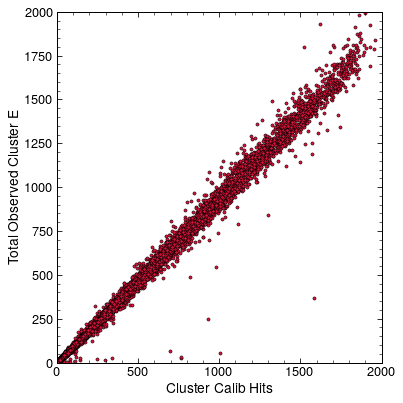

In [27]:
plt.cla(); plt.clf()
fig = plt.figure(figsize=(6,6))
fig.patch.set_facecolor('white')
plt.scatter(Y_eng, Y_clusterE, edgecolor='black', color='crimson', s=10)
# plt.title('cluster_ENG_CALIB_TOT Against Observed Total', fontsize=18)
plt.xlabel('Cluster Calib Hits', fontsize=14)
plt.ylabel('Total Observed Cluster E', fontsize=14)
plt.xlim(0,2000)
plt.ylim(0,2000)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()
plt.savefig('Plots/cluster_ENG_CALIB_TOT_clusterE_2021-06-03.png', format='png')
plt.show()

#### 2-D Histogram - CLUSTERS

<ipython-input-44-3093ece74a51>:8: RuntimeWarning: divide by zero encountered in true_divide
  plt.hist2d(Y_eng, Y_clusterE/Y_eng, bins=[xbin,ybin], norm=LogNorm())


<Figure size 432x288 with 0 Axes>

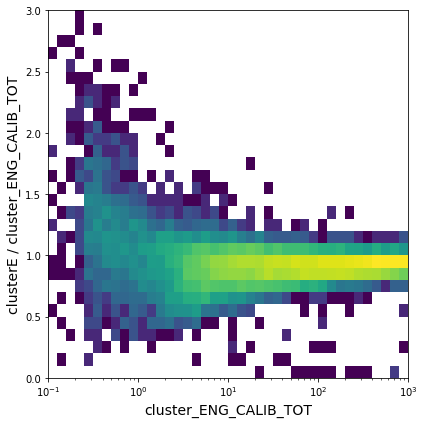

In [44]:
plt.cla(); plt.clf()

xbin = [10**exp for exp in  np.arange(-1.0, 3.1, 0.1)]
ybin = np.arange(0., 3.1, 0.1)

fig = plt.figure(figsize=(6,6))
fig.patch.set_facecolor('white')
plt.hist2d(Y_eng, Y_clusterE/Y_eng, bins=[xbin,ybin], norm=LogNorm())
plt.xlabel('cluster_ENG_CALIB_TOT', fontsize=14)
plt.ylabel('clusterE / cluster_ENG_CALIB_TOT', fontsize=14)
plt.xscale('log')
# plt.tight_layout()
# plt.savefig('Plots/clusterE_cluster_ENG_CALIB_TOT_track_data_2021-06-03.png', format='png')
plt.show()

#### 2-D Histogram - TRUTH PARTICLE

<Figure size 432x288 with 0 Axes>

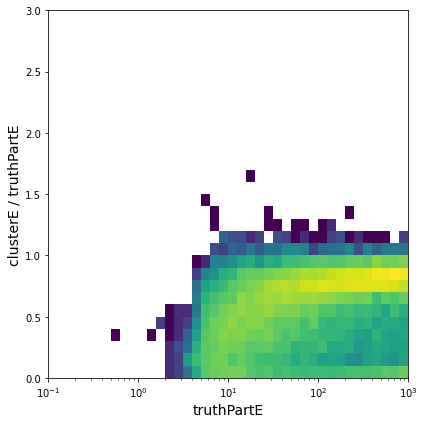

In [48]:
plt.cla(); plt.clf()

xbin = [10**exp for exp in  np.arange(-1.0, 3.1, 0.1)]
ybin = np.arange(0., 3.1, 0.1)

fig = plt.figure(figsize=(6,6))
fig.patch.set_facecolor('white')
plt.hist2d(Y_truth, Y_clusterE/Y_truth, bins=[xbin,ybin], norm=LogNorm())
plt.xlabel('truthPartE', fontsize=14)
plt.ylabel('clusterE / truthPartE', fontsize=14)
plt.xscale('log')
# plt.tight_layout()
# plt.savefig('Plots/truthPartE_clusterE_track_data_2021-06-03.png', format='png')
plt.show()

## Particle Flow With Max's Data
### No tracks!

In [61]:
dat = np.load('/fast_scratch/atlas_images/v01-45/pipm_medium.npz')
print(dat.files)

['X', 'Y_label', 'Y_target']


In [62]:
X = dat['X']
Y_label = dat['Y_label']
Y_target = dat['Y_target']
print('X size: '+str(np.shape(X)))
print('Y_label size: '+str(np.shape(Y_label)))
print('Y_target size: '+str(np.shape(Y_target)))

X size: (122850, 2000, 3)
Y_label size: (122850, 2)
Y_target size: (122850,)


## Testing -- Ignore Below

#### Shallow Copy

In [204]:
myarray = np.arange(25).reshape((5,5))
print(myarray)
newarray = myarray[:,0]
print(newarray)
myarray[:,0] = np.exp(myarray[:,0])
print(newarray)

[[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]
 [15 16 17 18 19]
 [20 21 22 23 24]]
[ 0  5 10 15 20]
[        1       148     22026   3269017 485165195]


#### Deep Copy

In [205]:
myarray = np.arange(25).reshape((5,5))
print(myarray)
newarray = np.ndarray.copy(myarray[:,0])
print(newarray)
myarray[:,0] = np.exp(myarray[:,0])
print(newarray)

[[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]
 [15 16 17 18 19]
 [20 21 22 23 24]]
[ 0  5 10 15 20]
[ 0  5 10 15 20]
